# Principal Componenet Analysis (PCA)

The PCA algorithm is a dimensionality reduction algorithm which works really well for datasets which have correlated columns. It combines the features of X in linear combination such that the new components capture the most information of the data. 

The model can take array-like objects, either in host as NumPy arrays or in device (as Numba or cuda_array_interface-compliant), as well as cuDF DataFrames as the input. 

For more information about cuDF, refer to the cuDF documentation: https://rapidsai.github.io/projects/cudf/en/latest/

For more information about cuML's PCA implementation: https://rapidsai.github.io/projects/cuml/en/latest/api.html#principal-component-analysis

In [2]:
import os
import numpy as np
import cupy as cp

import pylab as plt
from plt_style import *
%matplotlib inline

import pandas as pd
import cudf as gd

from cuml.datasets import make_blobs

from sklearn.decomposition import PCA as skPCA
from cuml.decomposition import PCA as cumlPCA
cp.cuda.Device(1).use()

## Define Parameters

In [3]:
n_samples = 2**15
n_features = 400

n_components = 2
whiten = False
random_state = 42
svd_solver = "full"

## Generate Data

### GPU

In [4]:
%%time
device_data, _ = make_blobs(n_samples=n_samples, 
                            n_features=n_features, 
                            centers=5, 
                            random_state=random_state)

device_data = gd.DataFrame.from_gpu_matrix(device_data)

CPU times: user 1.38 s, sys: 745 ms, total: 2.12 s
Wall time: 3.09 s


### Host

In [5]:
host_data = device_data.to_pandas()

## Scikit-learn Model

In [6]:
%%time
pca_sk = skPCA(n_components=n_components,
               svd_solver=svd_solver, 
               whiten=whiten, 
               random_state=random_state)

result_sk = pca_sk.fit_transform(host_data)

CPU times: user 5.28 s, sys: 3.84 s, total: 9.12 s
Wall time: 1.83 s


## cuML Model

In [7]:
%%time
pca_cuml = cumlPCA(n_components=n_components,
                   svd_solver=svd_solver, 
                   whiten=whiten,
                   random_state=random_state)

result_cuml = pca_cuml.fit_transform(device_data)

CPU times: user 990 ms, sys: 61.2 ms, total: 1.05 s
Wall time: 1.09 s


## Evaluate Results

### Singular Values

In [8]:
passed = np.allclose(pca_sk.singular_values_, 
                     pca_cuml.singular_values_, 
                     atol=0.01)
print('compare pca: cuml vs sklearn singular_values_ {}'.format('equal' if passed else 'NOT equal'))

compare pca: cuml vs sklearn singular_values_ equal


### Explained Variance

In [9]:
passed = np.allclose(pca_sk.explained_variance_, 
                     pca_cuml.explained_variance_, 
                     atol=1e-8)
print('compare pca: cuml vs sklearn explained_variance_ {}'.format('equal' if passed else 'NOT equal'))

compare pca: cuml vs sklearn explained_variance_ equal


### Explained Variance Ratio

In [10]:
passed = np.allclose(pca_sk.explained_variance_ratio_, 
                     pca_cuml.explained_variance_ratio_, 
                     atol=1e-8)
print('compare pca: cuml vs sklearn explained_variance_ratio_ {}'.format('equal' if passed else 'NOT equal'))

compare pca: cuml vs sklearn explained_variance_ratio_ equal


### Components

In [11]:
passed = np.allclose(pca_sk.components_, 
                     np.asarray(pca_cuml.components_.as_gpu_matrix()), 
                     atol=1e-6)
print('compare pca: cuml vs sklearn components_ {}'.format('equal' if passed else 'NOT equal'))

compare pca: cuml vs sklearn components_ equal


### Transform

In [12]:
passed = np.allclose(result_sk, np.asarray(result_cuml.as_gpu_matrix()), rtol=1e-2)
print('compare pca: cuml vs sklearn transformed results %s'%('equal'if passed else 'NOT equal'))

compare pca: cuml vs sklearn transformed results NOT equal


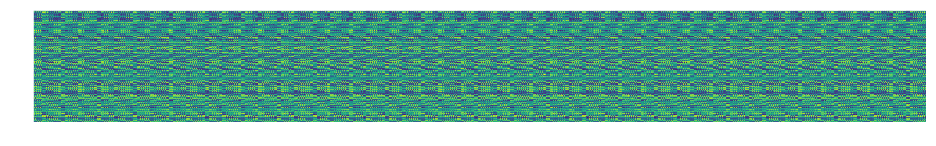

In [13]:
plt.figure(figsize=(16,16))
plt.imshow(host_data.values[:3200,:].T)

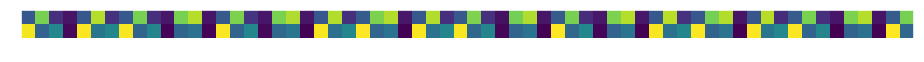

In [14]:
plt.figure(figsize=(16,16))
plt.imshow(result_sk[:64,:].T)

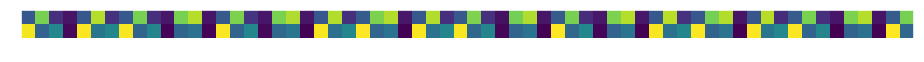

In [15]:
plt.figure(figsize=(16,16))
plt.imshow(result_cuml.as_matrix()[:64,:].T)